<a href="https://colab.research.google.com/github/so3500/2024-spark/blob/main/sungon/week4_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare Environment

Install Dependencies:


1.   Java 8
2.   Apache Spark with hadoop and
3.   Findspark (used to locate the spark in the system)

> If you have issues with spark version, please upgrade to the latest version from [here](https://archive.apache.org/dist/spark/).

In [ ]:
### java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

### spark & pyspark
#!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!cp /content/drive/MyDrive/2024_pyspark/spark-3.5.1-bin-hadoop3.tgz /content/
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark matplotlib

### test data
!cp -r /content/drive/MyDrive/2024_pyspark/stock_data /content/

# 구글 드라이브로 직접 csv 파일을 업로드하는 것 보다 압축파일 업로드 -> 마운트 -> 복사 -> 압축해제가 더 빠름
# 압축해제만 20초 소요 / 3400종목 / 3.61GB
!unzip -qq /content/stock_data/stock_nasdaq.zip

Set Environment Variables:

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder\
  .master("local[*]")\
  .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [ ]:
from pyspark.sql.dataframe import DataFrame

# Define a Peek Function
def peek(self, n=10):
  self.show(n)
  return self

# Monkey Patch the DataFrame Calss
DataFrame.peek = peek

# 주식 데이터 분석


## 데이터 준비

In [ ]:
from pyspark.sql.functions import col, avg, count, year, datediff, expr, min, max, filter, count_if, when, trim, to_date, month, input_file_name, regexp_extract
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, DoubleType

stock_lables = [
    ('date', StringType()),
    ('low', DoubleType()),
    ('open', DoubleType()),
    ('volumn', IntegerType()),
    ('high', DoubleType()),
    ('close', DoubleType()),
    ('adjusted_close', StringType()),
]
stock_schema = StructType([StructField(x[0], x[1], True) for x in stock_lables])

# NASAQ / 1565종목 / 841MB
# input_file_name() : file:///content/nasdaq_csv/AAPL.csv
stock_df = spark.read.csv('nasdaq_csv/', header=True, sep=",", schema=stock_schema)
print(f'before filtereing weather_df.count(): {stock_df.count():,}')

# add & type case column
stock_df = stock_df.withColumn('ticker', regexp_extract(input_file_name(), "([^/]+)\.csv", 1))\
  .withColumn('date', to_date('date', 'dd-MM-yyyy'))\
  .withColumn("volumn", stock_df["volumn"].cast(IntegerType()))\

# filter
stock_df = stock_df.filter(stock_df.date.isNotNull())\
  .filter(stock_df.low.isNotNull())\
  .filter(stock_df.open.isNotNull())\
  .filter(stock_df.volumn.isNotNull())\
  .filter(stock_df.high.isNotNull())\
  .filter(stock_df.close.isNotNull())\
  .filter(stock_df.adjusted_close.isNotNull())

# add column
from pyspark.sql.functions import year, month, weekofyear, dayofmonth
stock_df = stock_df.withColumn('year', year(stock_df.date))\
  .withColumn('month', month(stock_df.date))\
  .withColumn('day', dayofmonth(stock_df.date))\
  .withColumn('week', weekofyear(stock_df.date))

print(f'after filtereing weather_df.count(): {stock_df.count():,}')
stock_df.show(3)

before filtereing weather_df.count(): 8,752,326
after filtereing weather_df.count(): 7,998,945
+----------+-------------------+----+------+-------------------+-------------------+-------------------+------+----+-----+---+----+
|      date|                low|open|volumn|               high|              close|     adjusted_close|ticker|year|month|day|week|
+----------+-------------------+----+------+-------------------+-------------------+-------------------+------+----+-----+---+----+
|1973-02-21|0.39506199955940247| 0.0| 15188|0.39506199955940247|0.39506199955940247|0.39506199955940247|  DIOD|1973|    2| 21|   8|
|1973-02-22| 0.3703700006008148| 0.0|  9113| 0.3703700006008148| 0.3703700006008148| 0.3703700006008148|  DIOD|1973|    2| 22|   8|
|1973-02-23|0.34567898511886597| 0.0|  3038|0.34567898511886597|0.34567898511886597|0.34567898511886597|  DIOD|1973|    2| 23|   8|
+----------+-------------------+----+------+-------------------+-------------------+-------------------+------+--

### 아이디어

전체
- 가장 거래량이 적었던 날
- 가장 거래량이 많았던 날
- 가장 많은 종목이 오늘 날
- 가장 많은 종목이 내린 날
- 가장 오랫동안 오른 종목 e.g. 10거래일 연속

데이터 준비

In [ ]:
# 성능 높이기 : dataframe 을 메모리에 저장하여 연산 속도를 높임
stock_df.cache()
# stock_2020s_df = stock_df.filter('date >= "2020-01-01"')
# stock_2020s_df.cache()

date,low,open,volumn,high,close,adjusted_close,ticker,year,month,day,week
1973-02-21,0.39506199955940247,0.0,15188,0.39506199955940247,0.39506199955940247,0.39506199955940247,DIOD,1973,2,21,8
1973-02-22,0.3703700006008148,0.0,9113,0.3703700006008148,0.3703700006008148,0.3703700006008148,DIOD,1973,2,22,8
1973-02-23,0.34567898511886597,0.0,3038,0.34567898511886597,0.34567898511886597,0.34567898511886597,DIOD,1973,2,23,8
1973-02-26,0.34567898511886597,0.0,1519,0.34567898511886597,0.34567898511886597,0.34567898511886597,DIOD,1973,2,26,9
1973-02-27,0.34567898511886597,0.0,29869,0.34567898511886597,0.34567898511886597,0.34567898511886597,DIOD,1973,2,27,9
1973-02-28,0.34567898511886597,0.0,1519,0.34567898511886597,0.34567898511886597,0.34567898511886597,DIOD,1973,2,28,9
1973-03-01,0.3209879994392395,0.0,18225,0.3209879994392395,0.3209879994392395,0.3209879994392395,DIOD,1973,3,1,9
1973-03-02,0.3209879994392395,0.0,20250,0.3209879994392395,0.3209879994392395,0.3209879994392395,DIOD,1973,3,2,9
1973-03-05,0.34567898511886597,0.0,6075,0.34567898511886597,0.34567898511886597,0.34567898511886597,DIOD,1973,3,5,10
1973-03-06,0.3209879994392395,0.0,1519,0.3209879994392395,0.3209879994392395,0.3209879994392395,DIOD,1973,3,6,10


In [ ]:
# the most vloumn date
from pyspark.sql.functions import sum as _sum

stock_df.groupBy('date')\
  .agg(_sum('volumn').alias('volumn_sum'))\
  .orderBy(col('volumn_sum').desc())\
  .show(10)

# the most volumn by year & year of week
stock_df.groupBy('year', 'week')\
  .agg(_sum('volumn').alias('volumn_sum'))\
  .orderBy(col('volumn_sum').desc())\
  .show(10)

# the most volumn by year & month
stock_df.groupBy('year', 'month')\
  .agg(_sum('volumn').alias('volumn_sum'))\
  .orderBy(col('volumn_sum').desc())\
  .show(10)

# the most volumn by year
stock_df.groupBy('year')\
  .agg(_sum('volumn').alias('volumn_sum'))\
  .orderBy(col('volumn_sum').desc())\
  .show(10)

+----------+----------+
|      date|volumn_sum|
+----------+----------+
|2008-10-06|4832647902|
|2008-10-16|4689054057|
|2008-09-18|4536492718|
|2007-04-25|4472029047|
|2008-10-23|4412837988|
|2010-05-07|4411887653|
|2008-10-14|4398442274|
|2008-11-13|4287004436|
|2008-02-07|4274270252|
|2007-04-26|4265902863|
+----------+----------+
only showing top 10 rows

+----+----+-----------+
|year|week| volumn_sum|
+----+----+-----------+
|2008|  42|20317783656|
|2008|  41|19067046118|
|2008|  38|18421997411|
|2008|  44|17881196734|
|2008|   2|17445809097|
|2008|  47|17404327446|
|2010|   4|16678135602|
|2007|  17|16492550731|
|2011|  32|16283029038|
|2008|   5|16207069170|
+----+----+-----------+
only showing top 10 rows

+----+-----+-----------+
|year|month| volumn_sum|
+----+-----+-----------+
|2008|   10|80385626601|
|2008|    1|66091241952|
|2008|    7|60532229605|
|2008|    9|59968305336|
|2007|   11|59443688201|
|2008|    2|57903330330|
|2007|    8|57821596259|
|2008|   11|57781602151|
|

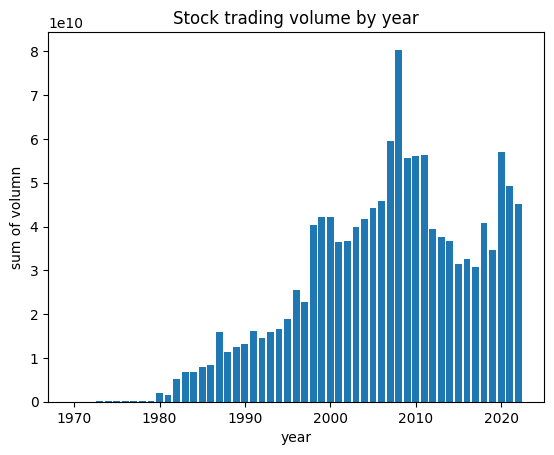

In [ ]:
import matplotlib.pyplot as plt

# the most volumn by year
volumn_sum_pandas = stock_df.groupBy('year', 'month')\
  .agg(_sum('volumn').alias('volumn_sum'))\
  .orderBy(col('year').asc(), col('month').asc())\
  .toPandas()

plt.bar(volumn_sum_pandas['year'], volumn_sum_pandas['volumn_sum'])
plt.xlabel('year')
plt.ylabel('sum of volumn')
plt.title('Stock trading volume by year')
plt.show()

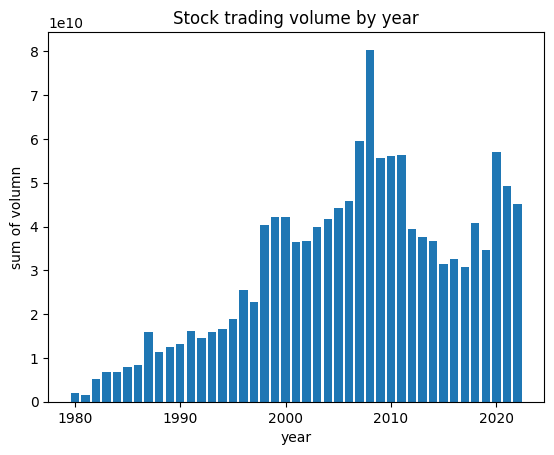

In [ ]:
# 상대적으로 거래량이 미미한 1980 이전 데이터 필터링
stock_1980_2023_df = stock_df.filter('year >= 1980')
# the most volumn by year
volumn_sum_pandas = stock_1980_2023_df.groupBy('year', 'month')\
  .agg(_sum('volumn').alias('volumn_sum'))\
  .orderBy(col('year').asc(), col('month').asc())\
  .toPandas()

plt.bar(volumn_sum_pandas['year'], volumn_sum_pandas['volumn_sum'])
plt.xlabel('year')
plt.ylabel('sum of volumn')
plt.title('Stock trading volume by year')
plt.show()

In [ ]:
# 가장 오랫동안 거래된(거래일이 많은) 종목 정렬
stock_df.groupBy('ticker')\
  .agg(count('*').alias('ticker_count'))\
  .orderBy(col('ticker_count').desc())\
  .show(20)

ticker_set = {'GT', 'TXN', 'DIOD', 'KLIC', 'MSEX', 'OTTR'}

+------+------------+
|ticker|ticker_count|
+------+------------+
|    GT|       13356|
|   TXN|       12744|
|  DIOD|       12564|
|  KLIC|       12564|
|  MSEX|       12564|
|  OTTR|       12564|
|   SGC|       12564|
| VLGEA|       12564|
|   PHI|       12514|
|  APOG|       12514|
|  ALCO|       12514|
|   MAT|       11724|
|  HELE|       11710|
|  TRNS|       11354|
|  TSRI|       11256|
|   WDC|       11125|
|  FARM|       10778|
|  PATK|       10778|
|  PCAR|       10778|
|  WABC|       10778|
+------+------------+
only showing top 20 rows



In [ ]:
# 주가 상승일이 많은 종목 정렬
stock_df.filter('close > open')\
  .groupBy('ticker')\
  .agg(count('*').alias('ticker_count'))\
  .orderBy(col('ticker_count').desc())\
  .show(20)

+------+------------+
|ticker|ticker_count|
+------+------------+
|  OTTR|        8262|
|  KLIC|        7824|
|   SGC|        7541|
|  DIOD|        7514|
|  WABC|        6733|
|  LANC|        6601|
|  NTRS|        6581|
| MOG-A|        6516|
|  SIGI|        6511|
|  CINF|        6510|
|  HELE|        6510|
|   WEN|        6470|
|  NDSN|        6440|
|  ZION|        6431|
|  HBAN|        6412|
|  FITB|        6398|
| KELYA|        6366|
|  SMTC|        6358|
|  MGEE|        6351|
|  SEIC|        6283|
+------+------------+
only showing top 20 rows



In [ ]:
# prompt: Stocks with a high share price increase rate per ticker over the entire trading day
stock_df.groupBy('ticker')\
  .agg(
      count_if(col('close') > col('open')).alias('rise_count'),
      count('*').alias('trade_date_count'))\
  .withColumn('rise_rate', col('rise_count') / col('trade_date_count'))\
  .orderBy(col('rise_rate').desc())\
  .show(30)


+------+----------+----------------+------------------+
|ticker|rise_count|trade_date_count|         rise_rate|
+------+----------+----------------+------------------+
|  OTTR|      8262|           12564|0.6575931232091691|
|  WABC|      6733|           10778|0.6246984598255706|
|  KLIC|      7824|           12564|0.6227316141356256|
|  LANC|      6601|           10778|0.6124512896641306|
|  NTRS|      6581|           10778|0.6105956578214882|
| MOG-A|      6516|           10727|0.6074391721823437|
|  SIGI|      6511|           10778|0.6041009463722398|
|  CINF|      6510|           10778|0.6040081647801077|
|   WEN|      6470|           10743|0.6022526296192869|
|   SGC|      7541|           12564|0.6002069404648201|
|  DIOD|      7514|           12564|0.5980579433301496|
|  NDSN|      6440|           10777|0.5975688967245059|
|  SEIC|      6283|           10520|0.5972433460076045|
|  ZION|      6431|           10778|0.5966784190016701|
|  HBAN|      6412|           10778|0.5949155687

In [ ]:
# 우리가 잘 하는 애플, 마이크로소프느는 어떨까?
stock_df.filter('ticker IN ("AAPL", "MSFT", "MVRS", "FB", "NVDA", "TESLA", "GOOGL", "GOOL")')\
  .groupBy('ticker')\
  .agg(
      count_if(col('close') > col('open')).alias('rise_count'),
      count('*').alias('trade_date_count'))\
  .withColumn('rise_rate', col('rise_count') / col('trade_date_count'))\
  .orderBy(col('rise_rate').desc())\
  .show(30)

+------+----------+----------------+------------------+
|ticker|rise_count|trade_date_count|         rise_rate|
+------+----------+----------------+------------------+
|  MSFT|      4587|            9264|0.4951424870466321|
|  NVDA|      2970|            6013|0.4939298187260935|
|  AAPL|      4807|           10555|0.4554239696826149|
+------+----------+----------------+------------------+



In [ ]:
# average days of close > open
stock_df.filter('close > open')\
  .groupBy('ticker')\
  .agg(count('*').alias('ticker_count'))\
  .agg(avg('ticker_count').alias('avg_ticker_count'))\
  .show()

# 50, 75, 95, 99 percential of close > open

# 50 percentail of close > open
print(stock_df.filter('close > open')\
  .groupBy('ticker')\
  .agg(count('*').alias('ticker_count'))\
  .approxQuantile('ticker_count', [0.5], 0.05))

# 75 percentail of close > open
print(stock_df.filter('close > open')\
  .groupBy('ticker')\
  .agg(count('*').alias('ticker_count'))\
  .approxQuantile('ticker_count', [0.75], 0.05))

# 90 percentail of close > open
print(stock_df.filter('close > open')\
  .groupBy('ticker')\
  .agg(count('*').alias('ticker_count'))\
  .approxQuantile('ticker_count', [0.90], 0.05))

# 95 percentail of close > open
print(stock_df.filter('close > open')\
  .groupBy('ticker')\
  .agg(count('*').alias('ticker_count'))\
  .approxQuantile('ticker_count', [0.95], 0.05))

# 99 percentail of close > open
print(stock_df.filter('close > open')\
  .groupBy('ticker')\
  .agg(count('*').alias('ticker_count'))\
  .approxQuantile('ticker_count', [0.99], 0.05))

+-----------------+
| avg_ticker_count|
+-----------------+
|2488.356638418079|
+-----------------+

[2197.0]
[3156.0]
[3924.0]
[8262.0]
[8262.0]
